# Persian Sentiment Analysis with BERT
using a Transformer BERT-based model for Persian sentiment analysis has become increasingly popular in recent years. BERT (Bidirectional Encoder Representations from Transformers) is a pre-trained neural network model that has achieved state-of-the-art performance in many natural language processing tasks, including sentiment analysis.

To use a BERT-based model for Persian sentiment analysis, one needs to fine-tune the pre-trained BERT model on a labeled dataset of Persian language text. Fine-tuning involves re-training the BERT model on the specific task of Persian sentiment analysis, by adjusting the weights of the pre-trained model using the labeled dataset.

The fine-tuned BERT model can then be used to classify new, unseen Persian language text into positive, or negative sentiment categories. One advantage of using a BERT-based model for Persian sentiment analysis is that it can capture the context and meaning of words in a sentence, which can be especially useful for analyzing sentiment in complex and nuanced Persian language text.

However, fine-tuning a BERT-based model for Persian sentiment analysis requires a large amount of labeled data and considerable computational resources. Additionally, the model may still struggle with the challenges unique to Persian language, such as the complex grammar and syntax, the presence of slang and informal language, and the lack of a comprehensive Persian language lexicon.

Overall, using a Transformer BERT-based model for Persian sentiment analysis has shown promising results and is an active area of research in the field of natural language processing.

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

Importing the libraries for sentiment classification

In [2]:
import transformers
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#checking if cuda is available

transformers.logging.set_verbosity_error()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
#defining general parameters

MAX_LEN = 256
BATCH_SIZE = 256
EPOCHS = 4

## model_name:
This is the name of a pre-trained BERT model for Persian language, which can be fine-tuned for various natural language processing tasks, including sentiment analysis.

## dataset_name: 
This is the path and filename of a CSV file containing a dataset of Persian language text for sentiment analysis.

In [5]:
model_name = 'HooshvareLab/bert-fa-base-uncased'
dataset_name = './Snappfood-Sentiment Analysis.csv'

persian_sentiment = pd.read_csv(dataset_name, delimiter='\t')

checking the data information such as the labels, if it has Nan values, etc

In [6]:
persian_sentiment.head()

,Unnamed: 0,comment,label,label_id
0,NaN,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1.0
1,NaN,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY,0.0
2,NaN,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,SAD,1.0
3,NaN,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,HAPPY,0.0
4,NaN,شیرینی وانیلی فقط یک مدل بود.,HAPPY,0.0


In [7]:
persian_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  520 non-null    object 
 1   comment     70000 non-null  object 
 2   label       70000 non-null  object 
 3   label_id    69480 non-null  float64
dtypes: float64(1), object(3)
memory usage: 2.1+ MB


In [8]:
print('the labels are : {}'.format(persian_sentiment.label.unique()))
print('the labels_id are : {}'.format(persian_sentiment.label_id.unique()))

print('label has {} missing values'.format(persian_sentiment.label.isna().sum()))
print('label_id has {} missing values'.format(persian_sentiment.label_id.isna().sum()))

the labels are : ['SAD' 'HAPPY' '1' '0']
the labels_id are : [ 1.  0. nan]
label has 0 missing values
label_id has 520 missing values


The label column contains the sentiment labels for each text sample in the dataset, and the output shows that there are four unique labels in the dataset: 'SAD', 'HAPPY', '1', and '0'.

The label_id column contains the sentiment labels represented as numerical values, and the output shows that there are two unique label IDs in the dataset: 0 and 1. Additionally, there are some missing values (NaN) in this column.

The last two lines of code print out the number of missing values in the label and label_id columns, respectively. The output shows that there are no missing values in the label column, but there are 520 missing values in the label_id column.

So, we need to map the sentiment labels from strings to binary labels, removing an unnecessary column, and creating a new column with the binary labels. The resulting dataset has two columns: text and label_id, where text contains the text samples and label_id contains the binary sentiment labels, with 1 indicating negative sentiment ('SAD' and '1') and 0 indicating positive sentiment ('HAPPY' and '0').

In [9]:
label_dict = {'SAD': 1, 'HAPPY': 0, '1': 1, '0': 0}
class_names = ['SAD', 'HAPPY']

persian_sentiment = persian_sentiment.drop(['label_id'], axis=1)
persian_sentiment['label_id'] = persian_sentiment.label.map(label_dict)
persian_sentiment = persian_sentiment.drop(['label'], axis=1)

Now lets split the splits the persian_sentiment dataset into three sets: 

X, which contains the features (i.e., the text samples), y, which contains the binary sentiment labels.

X_train and y_train, which contain 64% of the data and will be used to train the model.

X_test and y_test, which contain 20% of the data and will be used to test the model's performance.

X_val and y_val, which contain the remaining 16% of the data and will be used for validation during the training process.

In [10]:
X = persian_sentiment['comment'] # features
y = persian_sentiment['label_id'] # labels

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split train set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

The code computes and visualizes the class distribution in the training set y_train, which helps to identify whether the dataset is imbalanced or not. In this case, it appears that the dataset is slightly imbalanced, with a higher number of 1 sentiment samples than 0 sentiment samples. To handle this issue during training, the code computes the class weights for the dataset using the class_weight.compute_class_weight() function from scikit-learn. These weights can be used during the model optimization process to assign more importance to the minority class samples and prevent the model from being biased towards the majority class.

0    22420
1    22380
Name: label_id, dtype: int64


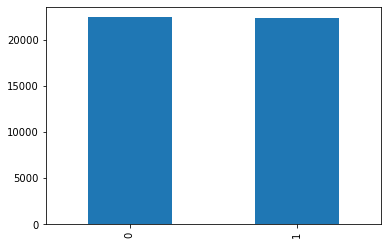

In [11]:
value_count= y_train.value_counts(sort=False)
print(value_count)
value_count.plot(kind='bar')

num_labels = len(value_count)

In [12]:
class_weights = list(class_weight.compute_class_weight(class_weight='balanced',
                                                       classes=np.unique(y_train),
                                                       y=y_train))

weights={}
for index, weight in enumerate(class_weights) :
  weights[index]=weight

print(weights)

{0: 0.9991079393398751, 1: 1.000893655049151}


Loading the Bert Tokenizer

BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review, and plot the distribution:

In [13]:
tokenizer = BertTokenizer.from_pretrained(model_name)

In [14]:
token_lens = []

for txt in X_train:
  tokens = tokenizer.encode(txt, max_length=MAX_LEN)
  token_lens.append(len(tokens))

/opt/conda/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


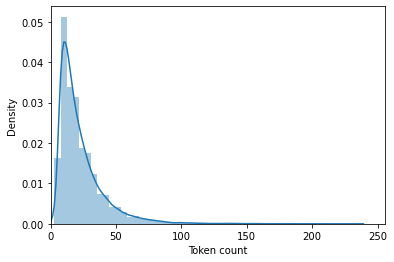

In [15]:
sns.distplot(token_lens)
plt.xlim([0, MAX_LEN]);
plt.xlabel('Token count');

In [16]:
#changing the MAXLEN to 100
MAX_LEN = 100

We have all building blocks required to create a PyTorch dataset. Let's do it:

In [17]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

We also need to create a couple of data loaders. Here's a helper function to do it:

In [18]:
def create_data_loader(x, y, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=x.to_numpy(),
    targets=y.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    shuffle = True
  )

In [19]:
train_data_loader = create_data_loader(X_train, y_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(X_val, y_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(X_test, y_test, tokenizer, MAX_LEN, BATCH_SIZE)

Let's have a look at an example batch from our training data loader:

In [20]:
data = next(iter(train_data_loader))
data.keys()

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [21]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([256, 100])
torch.Size([256, 100])
torch.Size([256])


Sentiment Classification with BERT and Hugging Face

Our classifier delegates most of the heavy lifting to the BertModel. We use a dropout layer for some regularization and a fully-connected layer for our output. Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

This should work like any other PyTorch model. Let's create an instance and move it to the GPU:

In [22]:
bert_model = BertModel.from_pretrained(model_name, return_dict=False)

In [23]:
class SentimentClassifier(torch.nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(model_name, return_dict= False)
    self.drop = torch.nn.Dropout(p=0.2)
    self.out = torch.nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [24]:
model = SentimentClassifier(num_labels)
model = model.to(device)

To reproduce the training procedure from the BERT paper, we'll use the AdamW optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [25]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(), lr=1e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = torch.nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))

Let's continue with writing a helper function for training our model for one epoch:

In [26]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [27]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [28]:
from collections import defaultdict

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(X_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(X_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc.item())
  history['train_loss'].append(train_loss.item())
  history['val_acc'].append(val_acc.item())
  history['val_loss'].append(val_loss.item())

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/4
----------
Train loss 0.37644243206296646 accuracy 0.8349107142857143
Val   loss 0.31743899800560693 accuracy 0.8691071428571429

Epoch 2/4
----------
Train loss 0.30160708802086966 accuracy 0.87265625
Val   loss 0.3045688555999236 accuracy 0.8730357142857142

Epoch 3/4
----------
Train loss 0.27952872123037065 accuracy 0.8838392857142857
Val   loss 0.3034981716085564 accuracy 0.8745535714285714

Epoch 4/4
----------
Train loss 0.2649516084364482 accuracy 0.8906919642857143
Val   loss 0.3057615685869347 accuracy 0.8752678571428572



 We can look at the training vs validation accuracy:

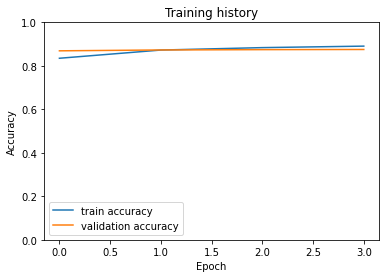

In [29]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

So how good is our model on predicting sentiment? Let's start by calculating the accuracy on the test data:

In [30]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(X_test)
)

test_acc.item()

0.8747142857142858

In [31]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = torch.nn.functional.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [32]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Let's have a look at the classification report

In [33]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         SAD       0.90      0.84      0.87      6982
       HAPPY       0.85      0.91      0.88      7018

    accuracy                           0.87     14000
   macro avg       0.88      0.87      0.87     14000
weighted avg       0.88      0.87      0.87     14000



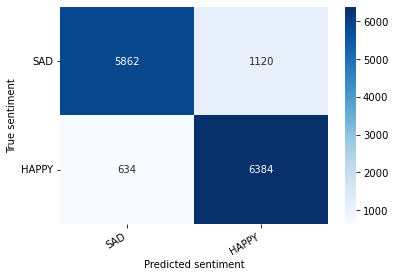

In [34]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)